## Forecast sales using store, promotion, and competitor data

 Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. 
 Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. 
By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them:
    their customers and their teams! 

In [7]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
# from quilt.data.ResidentMario import missingno_data
# import missingno as msno

import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv


from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics


ImportError: No module named 'catboost'

## loading the data

In [8]:
# Import train & test data 
train = pd.read_csv('/Users/anthonymiyoro/Desktop/Rossmann-Store-Sales-master/train.csv')
test = pd.read_csv('/Users/anthonymiyoro/Desktop/Rossmann-Store-Sales-master/test.csv')
store=pd.read_csv('/Users/anthonymiyoro/Desktop/Rossmann-Store-Sales-master/store.csv')
# sample_submission = pd.read_csv('C:/Users/David/Desktop/rossmann/sample_submission.csv') # example of what a submission should look like

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data description

 Most of the fields are self-explanatory. The following are descriptions for those that aren't.

##### Id  -an Id that represents a (Store, Date) duple within the test set

##### Store - a unique Id for each store

##### Sales - the turnover for any given day (this is what you are predicting)

##### Customers - the number of customers on a given day

##### Open - an indicator for whether the store was open: 0 = closed, 1 = open

##### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.  
                      a = public holiday, 
                      b = Easter holiday, 
                      c = Christmas, 
                      0 = None
                      
##### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

##### StoreType - differentiates between 4 different store models: a, b, c, d

##### Assortment - describes an assortment level: a = basic, b = extra, c = extended

##### CompetitionDistance - distance in meters to the nearest competitor store

##### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

##### Promo - indicates whether a store is running a promo on that day

##### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 
                          0 = store is not participating, 
                          1 = store is participating
                          
##### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

##### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## What missing values are there?

Where are the holes in our data?

These are rows which are missing a value or have NaN instead of something like the rest of the column.

In [9]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [11]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

## What datatypes are in the dataframe?

In [21]:
train['Date'] = pd.to_datetime(train['Date'], dayfirst=False)
test['Date'] = pd.to_datetime(test['Date'], dayfirst=False)

In [19]:
# Different data types in the dataset
train.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Sales                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

In [18]:
# Different data types in the dataset
test.dtypes

Id                        int64
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

## Let's explore each of these features individually

### Target Feature: Sales

Description:  the turnover for any given day

In [20]:
train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


There are 3 types of holidays a, b, and c. We will convert them to 1, 2, 3 to represent them

In [23]:
train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

convert categorical data to numeric data for state holiday

In [24]:
train.loc[train['StateHoliday'] == '0', 'StateHoliday'] = 0
train.loc[train['StateHoliday'] == 'a', 'StateHoliday'] = 1
train.loc[train['StateHoliday'] == 'b', 'StateHoliday'] = 2
train.loc[train['StateHoliday'] == 'c', 'StateHoliday'] = 3
train['StateHoliday'] = train['StateHoliday'].astype(int, copy=False)

In [25]:
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
5,6,5,2015-07-31,5651,589,1,1,0,1
6,7,5,2015-07-31,15344,1414,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
9,10,5,2015-07-31,7185,681,1,1,0,1


In [342]:
train['Date']=pd.to_datetime(train['Date'],dayfirst=False)

In [343]:
Date = train['Date']

pd.DataFrame({"year": Date.dt.year,
              "month": Date.dt.month,
              "day": Date.dt.day,
              #"hour": Date.dt.hour,
              "dayofyear": Date.dt.dayofyear,
              "week": Date.dt.week,
              "weekofyear": Date.dt.weekofyear,
              "dayofweek": Date.dt.dayofweek,
              "weekday": Date.dt.weekday,
              "quarter": Date.dt.quarter,
             })

,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,2015,7,31,212,31,31,4,4,3
1,2015,7,31,212,31,31,4,4,3
2,2015,7,31,212,31,31,4,4,3
3,2015,7,31,212,31,31,4,4,3
4,2015,7,31,212,31,31,4,4,3
5,2015,7,31,212,31,31,4,4,3
6,2015,7,31,212,31,31,4,4,3
7,2015,7,31,212,31,31,4,4,3
8,2015,7,31,212,31,31,4,4,3
9,2015,7,31,212,31,31,4,4,3


### The different types of school holidays

In [344]:
train['SchoolHoliday'].unique()

array([1, 0], dtype=int64)

### View of data

When theh

In [346]:
train['Open'].unique()

array([1, 0], dtype=int64)

## analysing test data set

In [347]:
test.shape

(41088, 8)

In [348]:
test['Year'] = pd.DatetimeIndex(test['Date']).year
test['Month'] = pd.DatetimeIndex(test['Date']).month

In [349]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,1,4,2015-09-17,1.0,1,0,0,2015,9
1,2,3,4,2015-09-17,1.0,1,0,0,2015,9
2,3,7,4,2015-09-17,1.0,1,0,0,2015,9
3,4,8,4,2015-09-17,1.0,1,0,0,2015,9
4,5,9,4,2015-09-17,1.0,1,0,0,2015,9


### Here we try and see all the information related to a particular store. We can see that data is recorded for every day of the stores operatio for 3 years.

In [351]:
print(train.ix[train['Store'] == 22])

         Store  DayOfWeek       Date  Year  Month  Customers  Open  Promo  \
21          22          5 2015-07-31  2015      7        633     1      1   
1136        22          4 2015-07-30  2015      7        575     1      1   
2251        22          3 2015-07-29  2015      7        525     1      1   
3366        22          2 2015-07-28  2015      7        525     1      1   
4481        22          1 2015-07-27  2015      7        621     1      1   
5596        22          7 2015-07-26  2015      7          0     0      0   
6711        22          6 2015-07-25  2015      7        415     1      0   
7826        22          5 2015-07-24  2015      7        592     1      0   
8941        22          4 2015-07-23  2015      7        501     1      0   
10056       22          3 2015-07-22  2015      7        436     1      0   
11171       22          2 2015-07-21  2015      7        468     1      0   
12286       22          1 2015-07-20  2015      7        503     1      0   

C:\Users\David\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


### We now take a look at the StateHoliday feature. '0' represents a working day while 'a'  represents a public holiday. We can change this to 0 and 1

In [26]:
test['StateHoliday'].unique()

array(['0', 'a'], dtype=object)

In [27]:
test['SchoolHoliday'].unique()

array([0, 1])

convert categorical data into state holiday into numerical data 

In [355]:
test.dtypes

Store              int64
DayOfWeek          int64
Date              object
Year               int64
Month              int64
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [29]:
test.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [30]:
train.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# Store Dataset

#### We now convert the store types to numerical data types

In [31]:
store.loc[store['StoreType'] == 'a', 'StoreType'] = 1
store.loc[store['StoreType'] == 'b', 'StoreType'] = 2
store.loc[store['StoreType'] == 'c', 'StoreType'] = 3
store.loc[store['StoreType'] == 'd', 'StoreType'] = 4
store['StoreType'] = store['StoreType'].astype(int, copy=False)

In [32]:
print('levels :', store['StoreType'].unique(), '; data type :', store['StoreType'].dtype)

levels : [3 1 4 2] ; data type : int64


#### The assortment of the store refers to the 3 different types of stores. We will convert this categorical data to numerical data 

In [33]:
store.loc[store['Assortment'] == 'a', 'Assortment'] = 1
store.loc[store['Assortment'] == 'b', 'Assortment'] = 2
store.loc[store['Assortment'] == 'c', 'Assortment'] = 3
store['Assortment'] = store['Assortment'].astype(int, copy=False)

In [34]:
print('levels :', store['Assortment'].unique(), '; data type :', store['Assortment'].dtype)

levels : [1 3 2] ; data type : int64


In [35]:
store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype=object)

In [36]:
store.dtypes

Store                          int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

#### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

We will now fill in the blank fields in the dataset with 0s

In [37]:
store = store.fillna(0)
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,1,1,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,3,3,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0
5,6,1,1,310.0,12.0,2013.0,0,0.0,0.0,0
6,7,1,3,24000.0,4.0,2013.0,0,0.0,0.0,0
7,8,1,1,7520.0,10.0,2014.0,0,0.0,0.0,0
8,9,1,3,2030.0,8.0,2000.0,0,0.0,0.0,0
9,10,1,1,3160.0,9.0,2009.0,0,0.0,0.0,0


### There are 3 different types pf promotion dates. Ww will convert this to numerical data by representing the different promotion dates with 1, 2 and 3

In [38]:
store.loc[store['PromoInterval'] == 'Jan,Apr,Jul,Oct', 'PromoInterval'] = 1
store.loc[store['PromoInterval'] == 'Feb,May,Aug,Nov', 'PromoInterval'] = 2
store.loc[store['PromoInterval'] == 'Mar,Jun,Sept,Dec', 'PromoInterval'] = 3
store['PromoInterval'] = store['PromoInterval'].astype(int, copy=False)

Merge train and store datasets before modeling the data.

In [39]:
train_store = pd.merge(train, store, how = 'left', on='Store')

In [44]:
train_store.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015-07-31,5263,555,1,1,0,1,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
2015-07-31,2,5,2015-07-31,6064,625,1,1,0,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,1
2015-07-31,3,5,2015-07-31,8314,821,1,1,0,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,1
2015-07-31,4,5,2015-07-31,13995,1498,1,1,0,1,3,3,620.0,9.0,2009.0,0,0.0,0.0,0
2015-07-31,5,5,2015-07-31,4822,559,1,1,0,1,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0


## Visual Exploration

#### We will begin by graphing the number of sales per month and year

In [43]:
train_store.set_index('Date', drop=False, inplace=True)

In [41]:
train_store.boxplot(column='Sales', by='Year')
plt.show()

KeyError: 'Year'

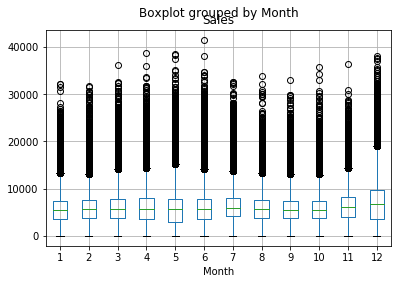

In [372]:
train_store.boxplot(column='Sales', by='Month')
plt.show()

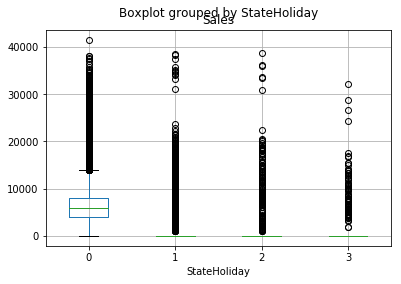

In [373]:
train_store.boxplot(column='Sales', by='StateHoliday')
plt.show()

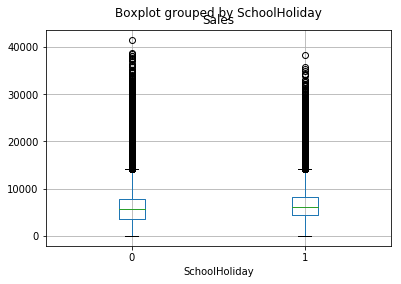

In [374]:
train_store.boxplot(column='Sales', by='SchoolHoliday')
plt.show()

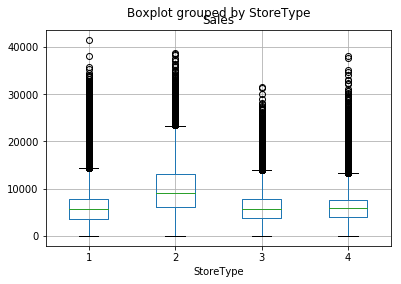

In [375]:
train_store.boxplot(column='Sales', by='StoreType')
plt.show()

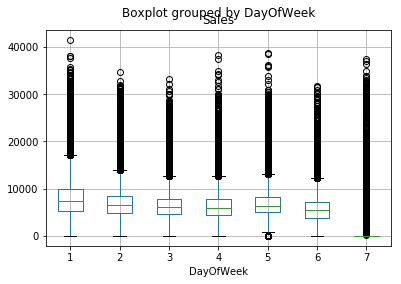

In [376]:
train_store.boxplot(column='Sales', by='DayOfWeek')
plt.show()

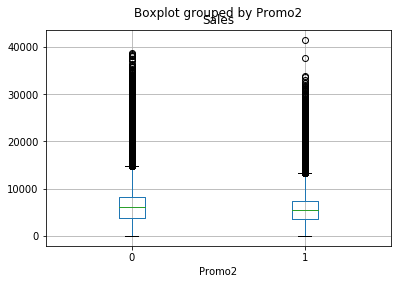

In [377]:
train_store.boxplot(column='Sales', by='Promo2')
plt.show()

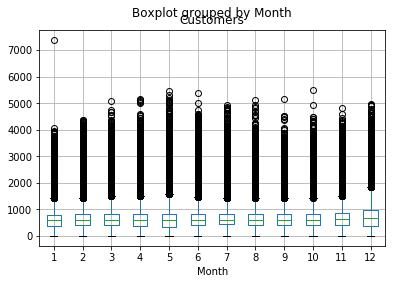

In [378]:
train_store.boxplot(column='Customers', by='Month')
plt.show()

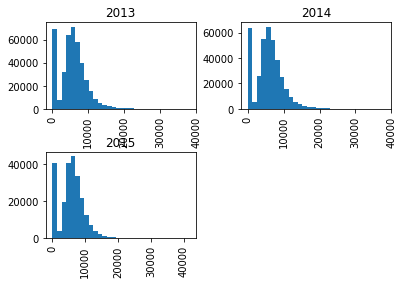

In [379]:
train_store.hist(column='Sales', by='Year', bins=30)
plt.show()

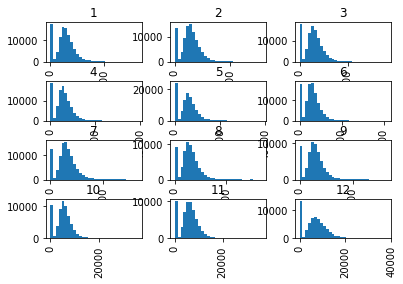

In [380]:
train_store.hist(column='Sales', by='Month', bins=30)
plt.show()

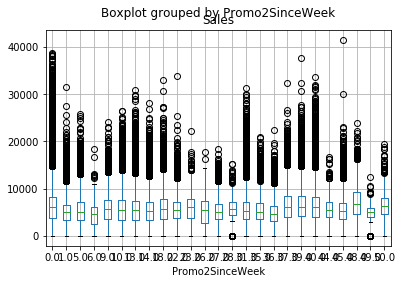

In [381]:
train_store.boxplot(column='Sales', by='Promo2SinceWeek')
plt.show()

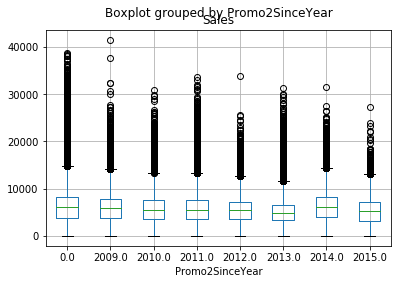

In [382]:
train_store.boxplot(column='Sales', by='Promo2SinceYear')
plt.show()

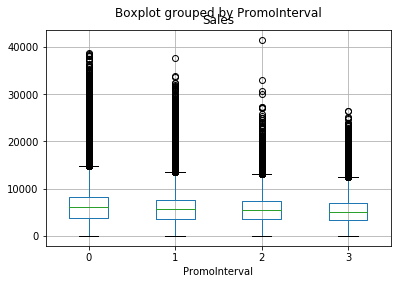

In [383]:
train_store.boxplot(column='Sales', by='PromoInterval')
plt.show()

In [384]:
train_store.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Year                                  int64
Month                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int32
SchoolHoliday                         int64
Sales                                 int64
StoreType                             int32
Assortment                            int32
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                         int32
dtype: object

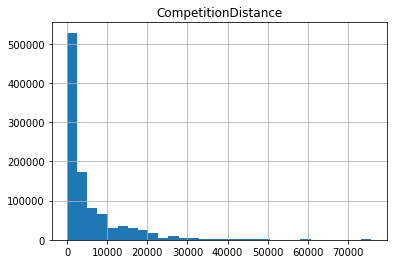

In [385]:
train_store.hist(column='CompetitionDistance', bins=30)
plt.show()

## Start Building Machine Learning Models
Now our data has been manipulating and converted to numbers, we can run a series of different machine learning algorithms over it to find which yield the best results.

### Let's seperate the data

In [386]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
train_store.tail(5)

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1017204,1111,2,2013-01-01,2013,1,0,0,0,1,1,0,1,1,1900.0,6.0,2014.0,1,31.0,2013.0,1
1017205,1112,2,2013-01-01,2013,1,0,0,0,1,1,0,3,3,1880.0,4.0,2006.0,0,0.0,0.0,0
1017206,1113,2,2013-01-01,2013,1,0,0,0,1,1,0,1,3,9260.0,0.0,0.0,0,0.0,0.0,0
1017207,1114,2,2013-01-01,2013,1,0,0,0,1,1,0,1,3,870.0,0.0,0.0,0,0.0,0.0,0
1017208,1115,2,2013-01-01,2013,1,0,0,0,1,1,0,4,3,5350.0,0.0,0.0,1,22.0,2012.0,3


In [1]:
del train_store['Year']
del train_store['Month']

NameError: name 'train_store' is not defined

In [390]:
#columns = ['Year', 'Month']
#train_store.drop(columns, inplace=True, axis=1)



In [405]:
train_store['Date']=pd.to_datetime(train_store['Date'],dayfirst=False)

In [406]:
Date = train_store['Date']

date_df = pd.DataFrame({"year": Date.dt.year,
              "month": Date.dt.month,
              "day": Date.dt.day,
              #"hour": Date.dt.hour,
              "dayofyear": Date.dt.dayofyear,
              "week": Date.dt.week,
              "weekofyear": Date.dt.weekofyear,
              "dayofweek": Date.dt.dayofweek,
              "weekday": Date.dt.weekday,
              "quarter": Date.dt.quarter,
             })

,year,month,day,dayofyear,week,weekofyear,dayofweek,weekday,quarter
0,2015,7,31,212,31,31,4,4,3
1,2015,7,31,212,31,31,4,4,3
2,2015,7,31,212,31,31,4,4,3
3,2015,7,31,212,31,31,4,4,3
4,2015,7,31,212,31,31,4,4,3
5,2015,7,31,212,31,31,4,4,3
6,2015,7,31,212,31,31,4,4,3
7,2015,7,31,212,31,31,4,4,3
8,2015,7,31,212,31,31,4,4,3
9,2015,7,31,212,31,31,4,4,3


In [407]:
train_store

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,2015,7,555,1,1,0,1,5263,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,2015,7,625,1,1,0,1,6064,1,1,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,2015-07-31,2015,7,821,1,1,0,1,8314,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,2015-07-31,2015,7,1498,1,1,0,1,13995,3,3,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,2015-07-31,2015,7,559,1,1,0,1,4822,1,1,29910.0,4.0,2015.0,0,0.0,0.0,0
5,6,5,2015-07-31,2015,7,589,1,1,0,1,5651,1,1,310.0,12.0,2013.0,0,0.0,0.0,0
6,7,5,2015-07-31,2015,7,1414,1,1,0,1,15344,1,3,24000.0,4.0,2013.0,0,0.0,0.0,0
7,8,5,2015-07-31,2015,7,833,1,1,0,1,8492,1,1,7520.0,10.0,2014.0,0,0.0,0.0,0
8,9,5,2015-07-31,2015,7,687,1,1,0,1,8565,1,3,2030.0,8.0,2000.0,0,0.0,0.0,0
9,10,5,2015-07-31,2015,7,681,1,1,0,1,7185,1,1,3160.0,9.0,2009.0,0,0.0,0.0,0


# # creating model 

In [408]:
# Labels are the values we want to predict
labels = np.array(train_store['Sales'])

In [409]:
# Remove the labels from the features

features= train_store.drop('Sales', axis = 1)

In [410]:
# Saving feature names for later use
feature_list = list(train_store.columns)
# Convert to numpy array
features = np.array(features)

## Training and Testing Sets

In [397]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [398]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

We can look at the shape of all the data to make sure we did everything correctly. We expect the training features number of columns to match the testing feature number of columns and the number of rows to match for the respective training and testing features and the labels

In [399]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (762906, 19)
Training Labels Shape: (762906,)
Testing Features Shape: (254303, 19)
Testing Labels Shape: (254303,)


## Train Model